In [172]:
import pymssql
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [173]:

database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data

In [174]:
def run_queries():
    tables = ["year", "month", "county", "median_income", "main_table"]

    query = f"SELECT * FROM {tables[0]}"
    year_df = sql_query(query)

    query = f"SELECT * FROM {tables[1]}"
    month_df = sql_query(query)

    query = f"SELECT * FROM {tables[2]}"
    county_df = sql_query(query)

    query = f"SELECT * FROM {tables[3]}"
    median_income_df = sql_query(query)

    query = f"SELECT * FROM {tables[4]}"
    main_table = sql_query(query)

    all_df = [year_df, month_df, county_df, median_income_df, main_table]
    return all_df

In [175]:
def join_tables(all_df):
    year_df = all_df[0]
    month_df = all_df[1]
    county_df = all_df[2]
    median_income_df = all_df[3]
    main_table = all_df[4]

    master_table = pd.merge(
        main_table, year_df, left_on="YearID", right_on="YearID", how="outer"
    )
    print(master_table.shape[0])
    # Now has 5607 rows

    master_table = pd.merge(
        master_table, month_df, left_on="MonthID", right_on="MonthID", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table, county_df, left_on="FIPS", right_on="FIPS", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table,
        median_income_df,
        left_on=["FIPS", "YearID"],
        right_on=["FIPS", "YearID"],
        how="outer",
    )
    # Now has 20727 rows
    print(master_table.shape[0])

    master_table.loc[(master_table.MedianIncome < 0), "MedianIncome"] = None
    return master_table

In [176]:
all_df = run_queries()
master_table = join_tables(all_df)

5607
5607
5607
20727


In [177]:
master_table.describe()

,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,MedianIncome
count,20727.000000,20727.000000,20727.000000,20727.000000,20706.000000,20727.000000,20727.000000,20727.000000,18888.000000
mean,12.629179,6.486322,96.352921,50.717615,320840.295711,4.782736,0.612563,2011.629179,63866.022872
std,5.015223,3.456069,105.821928,48.076455,108387.308961,1.111331,0.121310,5.015223,26138.573168
min,1.000000,1.000000,0.000000,0.000000,96963.000000,2.680000,0.400000,2000.000000,2499.000000
25%,9.000000,3.000000,30.000000,19.000000,231949.000000,3.910000,0.500000,2008.000000,43918.000000
50%,13.000000,6.000000,63.000000,37.000000,323147.000000,4.460000,0.600000,2012.000000,61402.000000
75%,17.000000,9.000000,127.000000,67.000000,410766.250000,5.820000,0.700000,2016.000000,81849.000000
max,23.000000,12.000000,1174.000000,696.000000,638470.000000,8.520000,1.000000,2022.000000,152424.000000


In [178]:
master_table.dropna(inplace=True)
final_table = master_table.copy()


In [179]:
#calculate monthly income
final_table['MonthlyIncome'] = final_table['MedianIncome']/12

#calculate montly mortgage payment
#https://www.educba.com/mortgage-formula/

for row in final_table:
    P = final_table['MedianHousePrice']-(final_table['MedianHousePrice']*.2).copy()
    r = (final_table['AverageRate']/100)
    t = 30
    n = 12
    monthly_tax = (final_table['MedianHousePrice']*.0189)/12
    final_table['MonthlyMortgage'] = (P * (((r/n) * pow((1+(r/n)),(n*t))) / (pow((1+r/n),(n*t))-1))) + monthly_tax


# mortgage to income ratio
final_table['mortgage_income_ratio'] = final_table['MonthlyMortgage']/final_table['MonthlyIncome']

#affordability determination
def affordable_condition(x):
    if x <= .25:
        return 'Yes'
    elif np.isnan(x):
        return 'Missing'
    else:
        return 'No'

final_table['affordable'] = final_table['mortgage_income_ratio'].apply(affordable_condition)
# print(final_table)

In [180]:
final_table

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,County,AgeGroup,MedianIncome,MonthlyIncome,MonthlyMortgage,mortgage_income_ratio,affordable
60,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,25-44,52040.0,4336.666667,1551.736115,0.357818,No
61,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,45-64,62816.0,5234.666667,1551.736115,0.296435,No
62,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,65-plus,30697.0,2558.083333,1551.736115,0.606601,No
63,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,overall,50377.0,4198.083333,1551.736115,0.369630,No
64,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,under-25,28074.0,2339.500000,1551.736115,0.663277,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20695,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,25-44,86705.0,7225.416667,1307.795634,0.180999,Yes
20696,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,45-64,101995.0,8499.583333,1307.795634,0.153866,Yes
20697,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,65-plus,55687.0,4640.583333,1307.795634,0.281817,No
20698,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,overall,84479.0,7039.916667,1307.795634,0.185769,Yes


In [181]:
# final_table['affordable'] = final_table.affordable.replace({1:'Yes', 0:'No'})
all_counties = pd.crosstab(final_table.County,final_table.affordable)

In [182]:
final_table

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,County,AgeGroup,MedianIncome,MonthlyIncome,MonthlyMortgage,mortgage_income_ratio,affordable
60,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,25-44,52040.0,4336.666667,1551.736115,0.357818,No
61,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,45-64,62816.0,5234.666667,1551.736115,0.296435,No
62,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,65-plus,30697.0,2558.083333,1551.736115,0.606601,No
63,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,overall,50377.0,4198.083333,1551.736115,0.369630,No
64,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,under-25,28074.0,2339.500000,1551.736115,0.663277,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20695,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,25-44,86705.0,7225.416667,1307.795634,0.180999,Yes
20696,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,45-64,101995.0,8499.583333,1307.795634,0.153866,Yes
20697,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,65-plus,55687.0,4640.583333,1307.795634,0.281817,No
20698,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,overall,84479.0,7039.916667,1307.795634,0.185769,Yes


In [183]:
all_counties

affordable,No,Yes
County,,
Atlantic County,654,246
Bergen County,893,7
Burlington County,469,431
Camden County,436,464
Cape May County,888,0
Cumberland County,351,549
Essex County,900,0
Gloucester County,453,447
Hudson County,900,0


In [184]:
# calculate percentage
all_counties['percent_affordable'] = (all_counties['Yes']/(all_counties['Yes'] + all_counties['No'])*100)
all_counties = all_counties.sort_values('percent_affordable')
all_counties = all_counties.reset_index()
bottom_5_counties = all_counties.head(5)
top_5_counties = all_counties.tail(5)

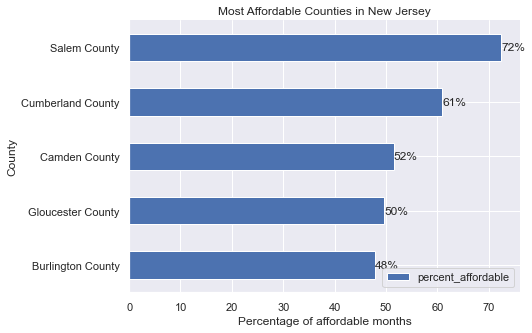

In [185]:
# plot most affordable counties
sns.set(rc={'figure.figsize':(7, 5)})
ax = top_5_counties.plot(title='Most Affordable Counties in New Jersey', kind='barh',\
    x='County',y='percent_affordable')
ax.set_xlabel('Percentage of affordable months')
ax.set_ylabel('County')
sns.despine()
for i in ax.containers:
    ax.bar_label(i,fmt='%.0f%%')

plt.show()


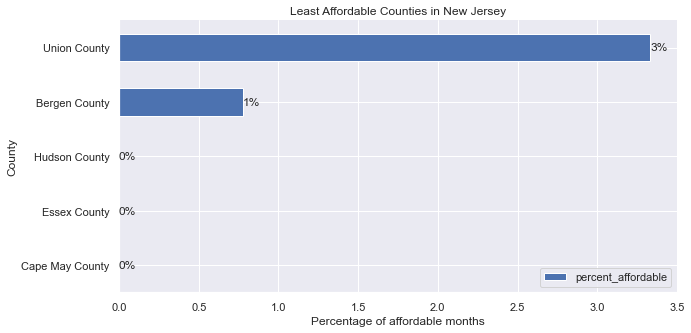

In [186]:
# plot least affordable counties
sns.set(rc={'figure.figsize':(10, 5)})
ax = bottom_5_counties.plot(title='Least Affordable Counties in New Jersey', kind='barh',\
    x='County',y='percent_affordable')
ax.set_xlabel('Percentage of affordable months')
ax.set_ylabel('County')
sns.despine()
plt.legend(loc='lower right')
for i in ax.containers:
    ax.bar_label(i,fmt='%.0f%%')

plt.show()

In [188]:
# final_table['affordable1'] = final_table.affordable.replace({1:'Yes', 0:'No'})
all_year = pd.crosstab(final_table.Year,final_table.affordable)

In [189]:
# calculate percentage
all_year['percent_affordable'] = (all_year['Yes']/(all_year['Yes'] + all_year['No'])*100)
all_year = all_year.sort_values('Year')
all_year = all_year.reset_index()
bottom_5_year = all_year.head(5)
top_5_year = all_year.tail(5)

In [190]:
all_year

affordable,Year,No,Yes,percent_affordable
0,2005,1154,106,8.412698
1,2006,1209,51,4.047619
2,2007,1211,49,3.888889
3,2008,1158,102,8.095238
4,2009,1020,240,19.047619
5,2010,977,283,22.460317
6,2011,912,348,27.619048
7,2012,799,461,36.587302
8,2013,811,449,35.634921
9,2014,837,413,33.040000


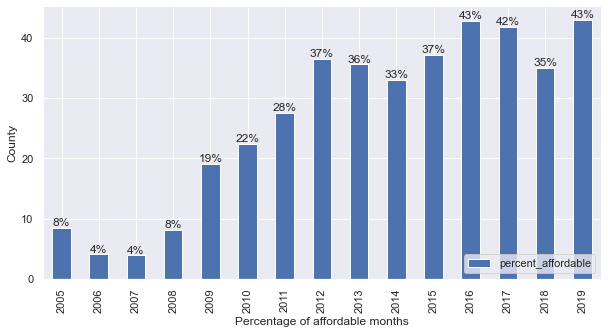

In [191]:
# plot least affordable counties
sns.set(rc={'figure.figsize':(10, 5)})
ax = all_year.plot(title='', kind='bar',\
    x='Year',y='percent_affordable')
ax.set_xlabel('Percentage of affordable months')
ax.set_ylabel('County')
sns.despine()
plt.legend(loc='lower right')
for i in ax.containers:
    ax.bar_label(i,fmt='%.0f%%')

plt.show()

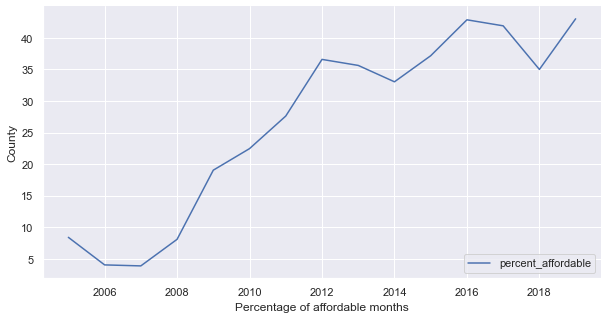

In [192]:
# plot least affordable counties
sns.set(rc={'figure.figsize':(10, 5)})
ax = all_year.plot(title='', kind='line',\
    x='Year',y='percent_affordable')
ax.set_xlabel('Percentage of affordable months')
ax.set_ylabel('County')
sns.despine()
plt.legend(loc='lower right')
for i in ax.containers:
    ax.bar_label(i,fmt='%.0f%%')

plt.show()

In [193]:
final_table

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,County,AgeGroup,MedianIncome,MonthlyIncome,MonthlyMortgage,mortgage_income_ratio,affordable
60,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,25-44,52040.0,4336.666667,1551.736115,0.357818,No
61,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,45-64,62816.0,5234.666667,1551.736115,0.296435,No
62,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,65-plus,30697.0,2558.083333,1551.736115,0.606601,No
63,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,overall,50377.0,4198.083333,1551.736115,0.369630,No
64,34001,6,1,107,103,249344.0,5.71,0.7,2005,Jan,Atlantic County,under-25,28074.0,2339.500000,1551.736115,0.663277,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20695,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,25-44,86705.0,7225.416667,1307.795634,0.180999,Yes
20696,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,45-64,101995.0,8499.583333,1307.795634,0.153866,Yes
20697,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,65-plus,55687.0,4640.583333,1307.795634,0.281817,No
20698,34041,20,12,10,6,248332.0,3.72,0.7,2019,Dec,Warren County,overall,84479.0,7039.916667,1307.795634,0.185769,Yes


In [194]:
year_income = final_table[['Year','MedianIncome']]
year_income = year_income.groupby(by=['Year']).agg('mean')
year_income.reset_index()

,Year,MedianIncome
0,2005,55701.790476
1,2006,56964.514286
2,2007,59812.114286
3,2008,62716.495238
4,2009,60051.819048
5,2010,60373.904762
6,2011,59539.457143
7,2012,61183.704762
8,2013,62626.666667
9,2014,64250.004800


In [195]:
year_hp = final_table[['Year','MedianHousePrice']]
year_hp = year_hp.groupby(by=['Year']).agg('mean')
year_hp.reset_index()

,Year,MedianHousePrice
0,2005,352056.428571
1,2006,387213.988095
2,2007,383069.587302
3,2008,359376.178571
4,2009,327567.242063
5,2010,316087.488095
6,2011,296657.087302
7,2012,282264.126984
8,2013,287156.123016
9,2014,299718.492000


In [196]:
year_income_hp = pd.merge(year_income,year_hp, on='Year', how='inner')
year_income_hp.reset_index()

,Year,MedianIncome,MedianHousePrice
0,2005,55701.790476,352056.428571
1,2006,56964.514286,387213.988095
2,2007,59812.114286,383069.587302
3,2008,62716.495238,359376.178571
4,2009,60051.819048,327567.242063
5,2010,60373.904762,316087.488095
6,2011,59539.457143,296657.087302
7,2012,61183.704762,282264.126984
8,2013,62626.666667,287156.123016
9,2014,64250.004800,299718.492000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


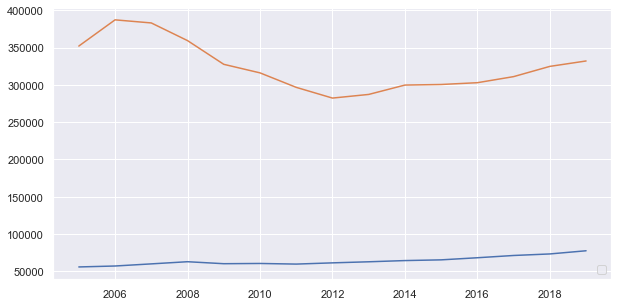

In [198]:
# plot least affordable counties
plt.plot(year_income_hp['MedianIncome'])
plt.plot(year_income_hp['MedianHousePrice'])
plt.legend(loc='lower right')
plt.show()